# Introduction

This is a basic example of using TOAST interactively for LiteBIRD simulations.  You can install the two packages with:

In [1]:
# ! pip install --pre toast
# ! pip install https://github.com/hpc4cmb/litebirdtask/archive/main.zip

This notebook uses additional packages that can be installed with pip or conda depending on the tool you are using to manage your environment:

In [2]:
#! pip install wurlitzer ipywidgets plotly plotly-resampler

Now import our modules:

In [3]:
# Built-in modules
import sys
import os
from datetime import datetime
import tempfile

# External modules
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import healpy as hp

# LiteBIRD and TOAST tools

import toast
import toast.ops
from toast import pixels_io_healpix as pio
import toast.widgets

import litebirdtask as lbt
from litebirdtask import vis as lbtv
from litebirdtask import ops


# Capture C++ output in the jupyter cells
%load_ext wurlitzer

# Display inline plots
%matplotlib inline

In [4]:
# Create a temporary directory for this notebook
temp_directory = tempfile.TemporaryDirectory()
tempdir = temp_directory.name

# Data Simulation

We start by creating a simulated LiteBIRD observing campaign with a scan strategy based on the instrument model and a few other parameters.  We then simulate detector timestream components to produce a realistic data set for analysis.

## Instrument Model

The rest of the notebook requires a local copy of the IMO.  This can be downloaded from the wiki (for example).  This file contains not only instrument parameters, but also default scanning parameters.

In [5]:
imo_file = "/home/kisner/git/litebird/IMoV2-14June.json"

## Simulated Observing

Next we are going to run a LiteBIRD scanning simulation.  We start with an empty TOAST data container.  For this notebook we are not using MPI, but MPI is supported both in standalone workflow scripts as well as notebooks using the MPI backend to ipyparallel.

The `SimObserve` operator here selects detectors based on regular expressions matching the telescope, channel, and wafer names.  The length of a science observation is a free parameter, along with the number of observations to simulate (up to the mission length).  The gap length is obtained from the duty cycle in the IMO, along with all the scanning parameters.

In [6]:
# Starting with empty Data container
data = toast.Data()

In [7]:
# Get help about an operator
?ops.SimObserve

In [8]:
# Simulate
sim_obs = ops.SimObserve(
    imo_file=imo_file,
    select_telescope="LFT",
    select_channel="L1-040",
    select_wafer=None,
    observation_time=60.0 * u.minute,
    num_observation=24,
    detset_key="pixel",
)
sim_obs.apply(data)

<SatelliteSchedule site=LiteBIRD telescope=LiteBIRD with 24 scans
  <SatelliteScan 'LB_000000_2031-03-21T00:00+00:00' at 2031-03-21T00:00:00+00:00 with prec period 192.348 min, spin period 20.0 min>
  <SatelliteScan 'LB_000001_2031-03-21T01:10+00:00' at 2031-03-21T01:10:35+00:00 with prec period 192.348 min, spin period 20.0 min>
  ... 
  <SatelliteScan 'LB_000022_2031-03-22T01:52+00:00' at 2031-03-22T01:52:56+00:00 with prec period 192.348 min, spin period 20.0 min>
  <SatelliteScan 'LB_000023_2031-03-22T03:03+00:00' at 2031-03-22T03:03:31+00:00 with prec period 192.348 min, spin period 20.0 min>
>
mission start = 2031-03-21 00:00:00+00:00
schedule = [<SatelliteScan 'LB_000000_2031-03-21T00:00+00:00' at 2031-03-21T00:00:00+00:00 with prec period 192.348 min, spin period 20.0 min>, <SatelliteScan 'LB_000001_2031-03-21T01:10+00:00' at 2031-03-21T01:10:35+00:00 with prec period 192.348 min, spin period 20.0 min>, <SatelliteScan 'LB_000002_2031-03-21T02:21+00:00' at 2031-03-21T02:21:10+00

/home/kisner/software/conda/envs/litebird/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/home/kisner/software/conda/envs/litebird/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


stamps = [1.93182607e+09 1.93182607e+09 1.93182607e+09 ... 1.93182967e+09
 1.93182967e+09 1.93182967e+09]
111600 : 1.931830305903226e+09 1.931833905870968e+09
stamps = [1.93183031e+09 1.93183031e+09 1.93183031e+09 ... 1.93183391e+09
 1.93183391e+09 1.93183391e+09]
111600 : 1.931834541193548e+09 1.931838141161290e+09
stamps = [1.93183454e+09 1.93183454e+09 1.93183454e+09 ... 1.93183814e+09
 1.93183814e+09 1.93183814e+09]
111600 : 1.931838776483871e+09 1.931842376451613e+09
stamps = [1.93183878e+09 1.93183878e+09 1.93183878e+09 ... 1.93184238e+09
 1.93184238e+09 1.93184238e+09]
111600 : 1.931843011774194e+09 1.931846611741935e+09
stamps = [1.93184301e+09 1.93184301e+09 1.93184301e+09 ... 1.93184661e+09
 1.93184661e+09 1.93184661e+09]
111600 : 1.931847247064516e+09 1.931850847032258e+09
stamps = [1.93184725e+09 1.93184725e+09 1.93184725e+09 ... 1.93185085e+09
 1.93185085e+09 1.93185085e+09]
111600 : 1.931851482354839e+09 1.931855082322581e+09
stamps = [1.93185148e+09 1.93185148e+09 1.9318

## Pointing Model

Our pointing model consists of 3 pieces.  The first is the detector pointing operator which translates boresight quaternions to the detector frame, with the Z-axis of the detector frame pointed at the detector line of sight and the X-axis of the detector frame aligned with the polarization sensitive direction.  The second piece is an operator which computes the pixel indices given a detector's pointing on the sky.  The final piece is an operator which computes the Stokes weights for each detector sample.  In this example we are using default operators in TOAST, but could implement other operators specific to LiteBIRD (for example a more detailed HWP response).  We use a low resolution pixelization for this example.

In [9]:
det_pntg = toast.ops.PointingDetectorSimple()

det_pixels = toast.ops.PixelsHealpix(
    nest=True,
    nside=128,
    detector_pointing=det_pntg,
)

det_weights = toast.ops.StokesWeights(
    mode="IQU",
    detector_pointing=det_pntg,
    hwp_angle=sim_obs.hwp_angle,
)

## Default Noise Model

We will estimate the noise below, but we can also create a default noise model based purely on nominal detector values.

In [10]:
default_model = toast.ops.DefaultNoiseModel()
default_model.apply(data)

## Simulated Timestream Components

We can simulate a variety of detector data components.

### Dipole

This will simulate the solar plus orbital dipole, but the orbit is not simulated yet within the `LitebirdSite` class, and so this will only include the motion of the Earth.

In [11]:
sim_dipole = toast.ops.SimDipole(
    freq=40.0 * u.GHz,
    mode="total",
)
sim_dipole.apply(data)

### Fake Sky

In order to avoid downloading a signal map in this notebook, we will just generate a fake synthetic sky.  This is just for visualization and has no physical meaning.

setting the output map dtype to [dtype('float64'), dtype('float64'), dtype('float64')]


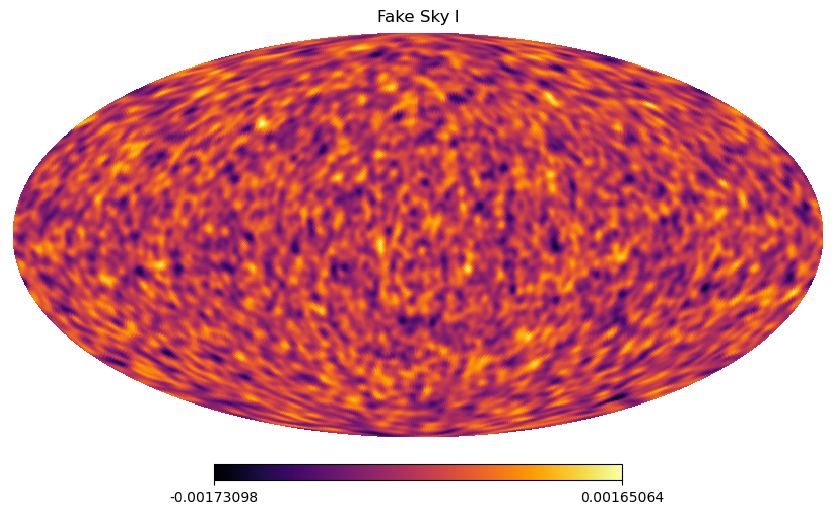

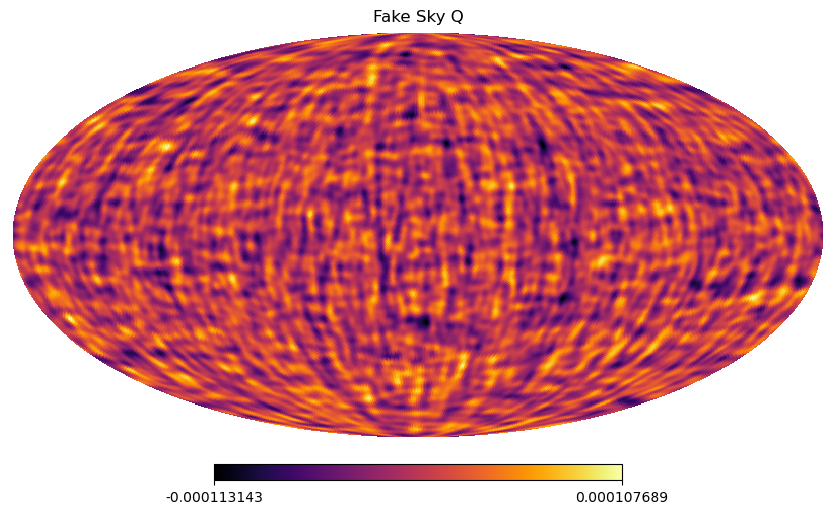

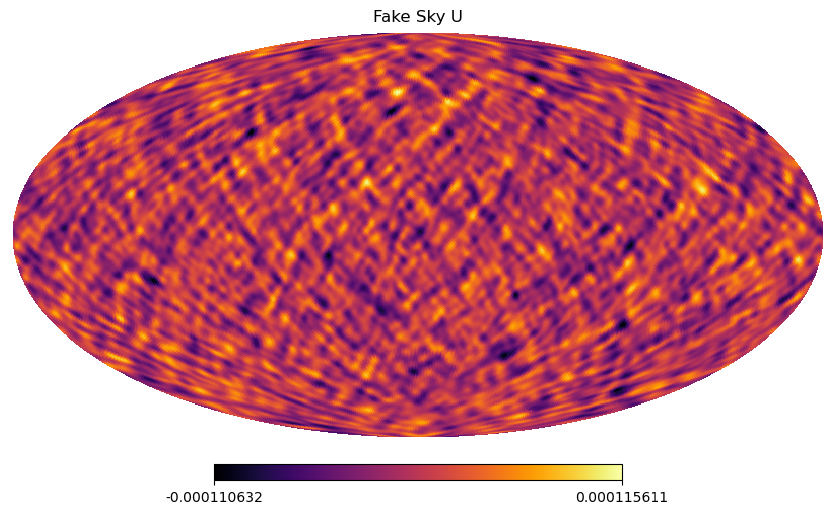

In [12]:
lmax = 2 * det_pixels.nside
cl = np.zeros(4 * (lmax + 1)).reshape([4, -1])
cl[0, :] = 1.0e-9 * np.ones(lmax + 1)
cl[1, :] = 1.0e-10 * np.ones(lmax + 1)
cl[2, :] = 1.0e-11 * np.ones(lmax + 1)
fake_I, fake_Q, fake_U = hp.synfast(
    cl,
    det_pixels.nside,
    pol=True,
    lmax=lmax,
    fwhm=np.radians(3.0),
    verbose=False,
)

fake_sky_file = os.path.join(tempdir, "fake_input_sky.fits")
hp.write_map(fake_sky_file, [fake_I, fake_Q, fake_U])

hp.mollview(fake_I, title="Fake Sky I", cmap="inferno")
hp.mollview(fake_Q, title="Fake Sky Q", cmap="inferno")
hp.mollview(fake_U, title="Fake Sky U", cmap="inferno")


In [13]:
# Now scan this into a map
sim_map_scan = toast.ops.ScanHealpixMap(
    file=fake_sky_file,
    pixel_pointing=det_pixels,
    stokes_weights=det_weights,
)
sim_map_scan.apply(data)

TOAST INFO: Pixel data in /tmp/tmpr21r7xk9/fake_input_sky.fits does not have TUNIT1 key.  Assuming 'K'.


### Instrumental Noise

For this small example, we are just simulating per-detector 1/f noise from the nominal noise model, but we could also simulate correlated noise by creating a suitable `Noise` object for each observation that had a mixing matrix describing the correlations.

In [14]:
sim_noise = toast.ops.SimNoise(
    noise_model=default_model.noise_model,
)
sim_noise.apply(data)

### Saving Data

If we want to save this simulated data for later we can do that now.  Here we use the TOAST native HDF5 format with FLAC compression for the detector signal and gzip for the flags.

In [15]:
hdf5_volume = os.path.join(tempdir, "data")

save_hdf5 = toast.ops.SaveHDF5(
    volume=hdf5_volume,
    detdata=[
        (sim_obs.det_data, {"type": "flac"}),
        (sim_obs.det_flags, {"type": "gzip"}),
    ]
)

# save_hdf5.apply(data)

# Data Exploration

You can directly access / modify / plot data stored within the TOAST containers.  Each `Observation` is independent, so for this exercise we can look at just the first observation.

In [16]:
first_ob = data.obs[0]
print(first_ob)

<Observation
  name = 'LB_000000_2031-03-21T00:00+00:00_1931817600_LFT_L1-040'
  uid = '185262870'  group has a single process (no MPI)
  telescope = <Telescope 'LFT_L1-040': uid = 4199931769, site = <SpaceSite 'LiteBIRD' : uid = 763051199>, focalplane = <Focalplane: 48 detectors, sample_rate = 31.0 Hz, FOV = 18.503199999999968 deg, detectors = [000_000_003_QA_040_B .. 000_007_008_QB_040_T]>>
  session = <Session 'LB_000000_2031-03-21T00:00+00:00_1931817600': uid = 3053134906, start = 2031-03-21 00:00:00+00:00, end = 2031-03-21 01:00:00+00:00>
  noise_model = <AnalyticNoise model with 48 detectors>
  111601 total samples (111601 local)
  shared:  <SharedDataManager
    times (column): shape=(111601,), dtype=float64
    flags (column): shape=(111601,), dtype=uint8
    position (column): shape=(111601, 3), dtype=float64
    velocity (column): shape=(111601, 3), dtype=float64
    boresight_radec (column): shape=(111601, 4), dtype=float64
    hwp_angle (column): shape=(111601,), dtype=floa

In the last cell you can see that the `Observation` has several "shared" data fields containing the pointing information and some other empty types of data "detdata" and "intervals".  We can just print these like a numpy array:

In [17]:
print(first_ob.shared["times"])

<MPIShared
  replicated on 1 nodes, each with 1 processes (1 total)
  shape = (111601,), dtype = float64
  [ 1931817600.0 1931817600.032258 ... 1931821199.967742 1931821200.0 ]
>


You can see that the "shared" data buffers are a special kind of array that (if MPI is being used) have only a single copy on each compute node.  You can access individual elements with normal slice notation, or you can get a numpy array view by accessing the `.data` attribute.  For example we can plot them:

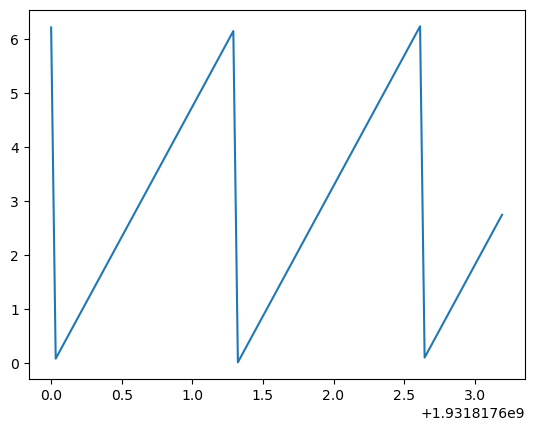

In [18]:
# Plot HWP angle vs time for the first observation
times = first_ob.shared["times"]
hwp = first_ob.shared["hwp_angle"]

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(times.data[:100], hwp.data[:100])

plt.show()

The `detdata` attribute of an observation contains just the local data on each process, so you can read and write to these arrays.  The named keys in this `detdata` dictionary allow us to access the data by detector name, detector index, or sample range:

In [19]:
signal = first_ob.detdata["signal"]

In [20]:
print(signal["000_000_003_QA_040_B"])

[-0.00045075 -0.00059685  0.00134057 ...  0.00149111 -0.00064773
 -0.00110936]


In [21]:
print(signal[["000_000_003_QA_040_B", "000_000_003_QA_040_T"], 0:4])

[[-0.00045075 -0.00059685  0.00134057 -0.00110243]
 [-0.00185807 -0.00014141 -0.00092465 -0.0004503 ]]


In [22]:
# The whole thing...
print(signal[:, :])

[[-4.50751008e-04 -5.96850856e-04  1.34056743e-03 ...  1.49110533e-03
  -6.47726464e-04 -1.10935740e-03]
 [-1.85806641e-03 -1.41405493e-04 -9.24651773e-04 ... -8.17653339e-04
  -1.49002876e-03  8.12900589e-04]
 [-2.48070811e-04 -1.03191385e-03 -1.02424382e-03 ... -1.21857355e-03
  -1.61881445e-03 -1.69179436e-03]
 ...
 [-8.61443724e-04 -8.44750625e-04 -1.26756331e-03 ... -6.73228914e-05
  -6.98972198e-04 -4.78147905e-04]
 [-4.81617315e-05  1.50217092e-03  4.95066262e-05 ... -6.14938298e-04
  -1.54268679e-03 -1.99669270e-03]
 [-2.67245205e-04  6.13331187e-04 -2.02451042e-06 ... -1.41199601e-03
  -6.77197066e-04  4.66247360e-04]]


You can plot some detector data relative to the timestamps, for example:

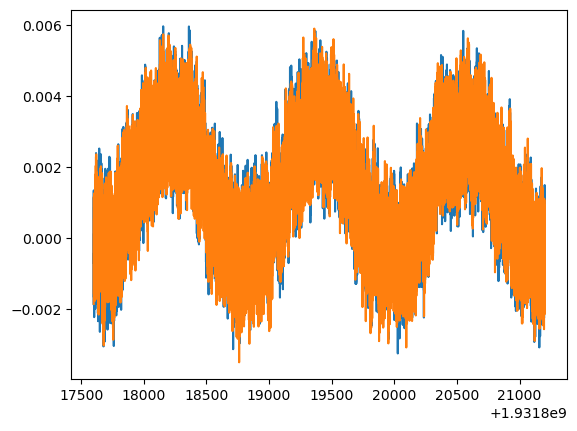

In [23]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(
    times.data, 
    signal["000_000_003_QA_040_B"],
)

ax.plot(
    times.data, 
    signal["000_000_003_QA_040_T"],
)

plt.show()

The `Observation` class also gives us access to the focalplane properties for this observation:

In [24]:
# The telescope for this observation
print(first_ob.telescope)

<Telescope 'LFT_L1-040': uid = 4199931769, site = <SpaceSite 'LiteBIRD' : uid = 763051199>, focalplane = <Focalplane: 48 detectors, sample_rate = 31.0 Hz, FOV = 18.503199999999968 deg, detectors = [000_000_003_QA_040_B .. 000_007_008_QB_040_T]>>


In [25]:
# The focalplane
print(first_ob.telescope.focalplane)

<Focalplane: 48 detectors, sample_rate = 31.0 Hz, FOV = 18.503199999999968 deg, detectors = [000_000_003_QA_040_B .. 000_007_008_QB_040_T]>


In [26]:
# The Table of detector properties
print(first_ob.telescope.focalplane.detector_data.info)
print(first_ob.telescope.focalplane.detector_data)

<QTable length=48>
      name       dtype  shape    unit     class  
--------------- ------- ----- ---------- --------
           name   str20                    Column
          wafer    str3                    Column
          pixel   int64                    Column
        pixtype    str3                    Column
          squid   int64                    Column
           quat float64  (4,)              Column
          gamma float64              rad Quantity
        psi_pol float64              rad Quantity
    pol_leakage float32                    Column
           fwhm float64           arcmin Quantity
    ellipticity float64                    Column
     bandcenter float64              GHz Quantity
      bandwidth float64              GHz Quantity
        psd_net float64         K s(1/2) Quantity
      psd_fknee float64               Hz Quantity
       psd_fmin float64               Hz Quantity
      psd_alpha float64                    Column
            pol    str1        

### Interactive Visualization

The next line launches an interactive ipython widget.  If you are running the whole notebook at once, comment out this line, since it will cause the kernel to run forever.

In [27]:
# w = toast.widgets.ObservationWidget(data.obs[0])

# Data Reduction

Now we consider the previous data set and analyze this.  Here we use the data already simulated in memory, but could also load the data from disk.  For this example, we do not perform focalplane reconstruction- that is a future exercise.  We also do not demonstrate either HWP demodulation (which is supported in TOAST) or regression of HWP synchronous signal in the map-making (which is nearing completion).

## Noise Estimation

Here we estimate the noise assuming that the timestreams are noise dominated and fit those estimates to a 1/f model.  In practice, since we have not removed the dipole, we expect this to show up as a large additional 1/f model.

In [28]:
noise_estim = toast.ops.NoiseEstim(
    out_model="noise_est",
    lagmax=4096,
    nbin_psd=64,
    nsum=1,
    naverage=128,
)
noise_estim.apply(data)

In [29]:
noise_fit = toast.ops.FitNoiseModel(
    noise_model=noise_estim.out_model,
    out_model="fit_noise",
    least_squares_ftol=None,
    least_squares_xtol=1.0e-12,
    least_squares_gtol=None,
)
noise_fit.apply(data)

Plot the noise estimate and fit for a couple detectors within one observation.  Note the large 1/f due to the un-removed dipole.

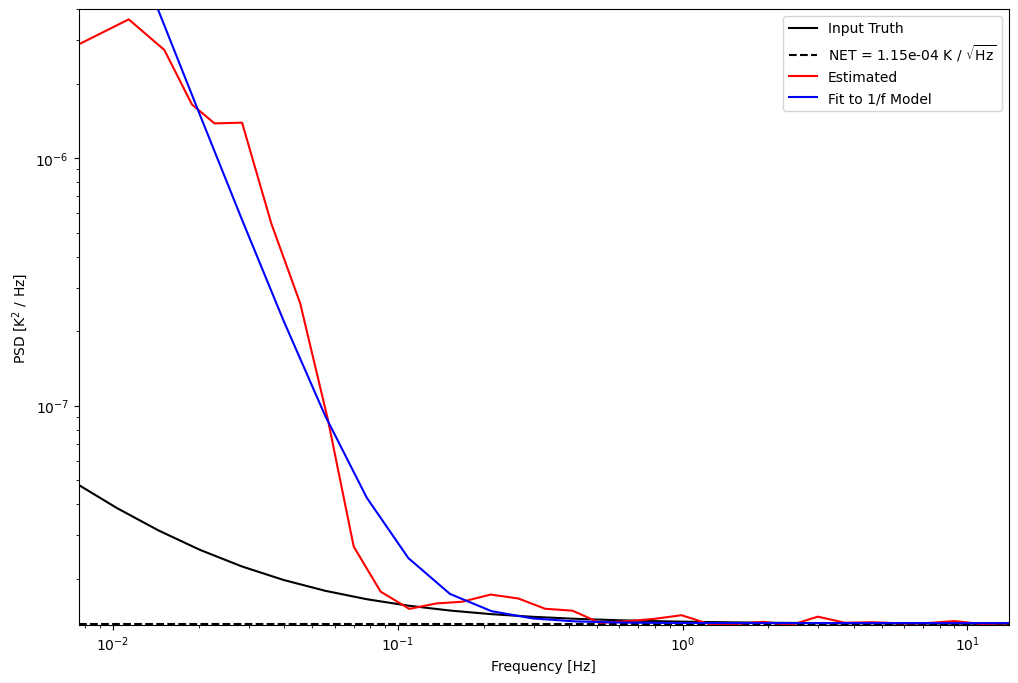

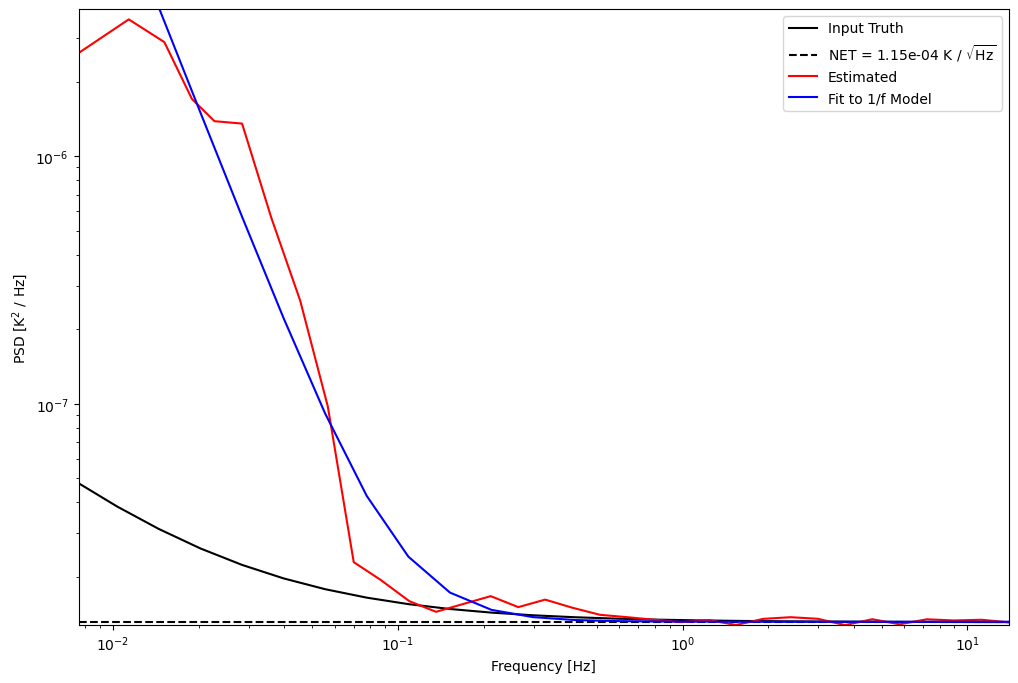

In [30]:
sim_noise = first_ob[default_model.noise_model]
est_noise = first_ob[noise_estim.out_model]
fit_noise = first_ob[noise_fit.out_model]

for idet in range(2):
    det_name = first_ob.local_detectors[idet]
    toast.vis.plot_noise_estim(
        None,
        est_noise.freq(det_name),
        est_noise.psd(det_name),
        fit_freq=fit_noise.freq(det_name),
        fit_psd=fit_noise.psd(det_name),
        true_net=sim_noise.NET(det_name),
        true_freq=sim_noise.freq(det_name),
        true_psd=sim_noise.psd(det_name),
        semilog=False,
    )

## Map Making

Next we will make a basic map using a single regression template representing baseline offsets.

In [31]:
# Use a single Offset template (destriping baselines)
baselines = toast.templates.Offset(
    noise_model=noise_fit.out_model,
    step_time=2.0 * u.second,
)

In [32]:
# Template matrix with these templates
tmatrix = toast.ops.TemplateMatrix(
    templates=[baselines],
)

In [33]:
# Binning operator
binner = toast.ops.BinMap(
    pixel_pointing=det_pixels,
    stokes_weights=det_weights,
    noise_model=noise_fit.out_model,
)

In [34]:
# Optionally save full detector pointing.  This speeds up the mapmaking dramatically,
# but results in a 5x increase in memory.
binner.full_pointing = True

In [35]:
out_dir = os.path.join(tempdir, "maps")
if not os.path.isdir(out_dir):
    os.makedirs(out_dir)

mapper = toast.ops.MapMaker(
    binning=binner,
    template_matrix=tmatrix,
    solve_rcond_threshold=1e-3,
    map_rcond_threshold=1e-3,
    iter_min=40,
    iter_max=100,
    write_hits=True,
    write_map=True,
    write_binmap=True,
    write_cov=True,
    output_dir=out_dir,
)

In [36]:
mapper.apply(data)

TOAST INFO: SolveAmplitudes begin building flags for solver
TOAST INFO: SolveAmplitudes  finished flag building in 0.19 s
TOAST INFO: SolveAmplitudes begin build of solver covariance
TOAST INFO: SolveAmplitudes  finished build of solver covariance in 12.20 s
TOAST INFO: SolveAmplitudes Solver flags cut 54 / 128563248 = 0.00% of samples
TOAST INFO: SolveAmplitudes begin RHS calculation
TOAST INFO: SolveAmplitudes  finished RHS calculation in 9.67 s
TOAST INFO: SolveAmplitudes begin PCG solver
TOAST INFO: MapMaker initial residual = 592387699219359.5, 2.07 s
TOAST INFO: MapMaker iteration    0, relative residual = 5.000658e-03, 1.89 s
TOAST INFO: MapMaker iteration    1, relative residual = 9.214160e-04, 2.14 s
TOAST INFO: MapMaker iteration    2, relative residual = 3.224378e-04, 2.36 s
TOAST INFO: MapMaker iteration    3, relative residual = 1.639495e-04, 1.85 s
TOAST INFO: MapMaker iteration    4, relative residual = 1.007504e-04, 1.82 s
TOAST INFO: MapMaker iteration    5, relative r

Now plot the output maps and residual compared to the input fake sky:

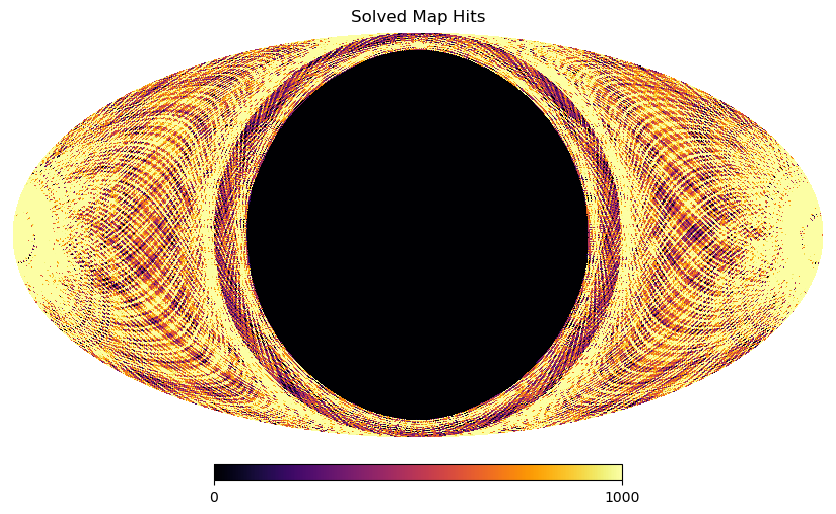

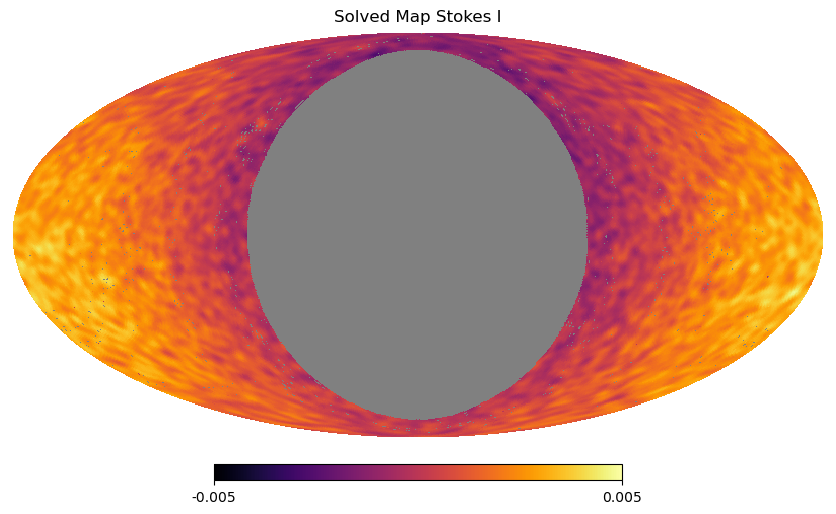

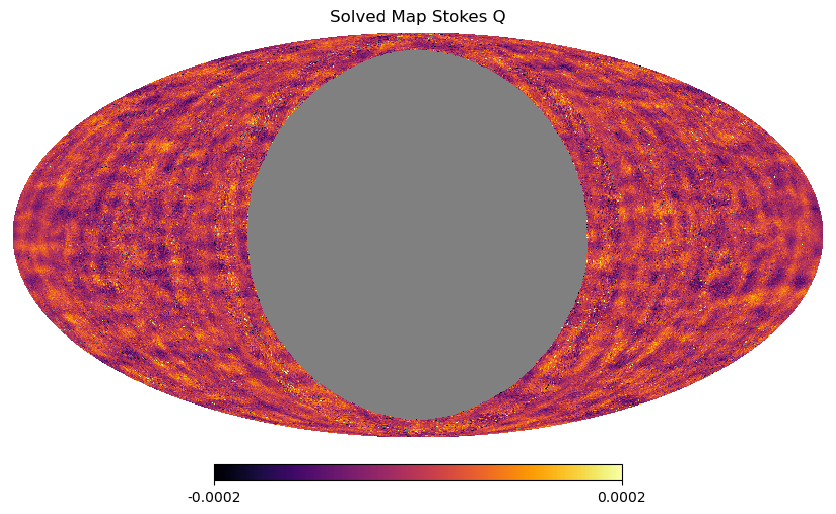

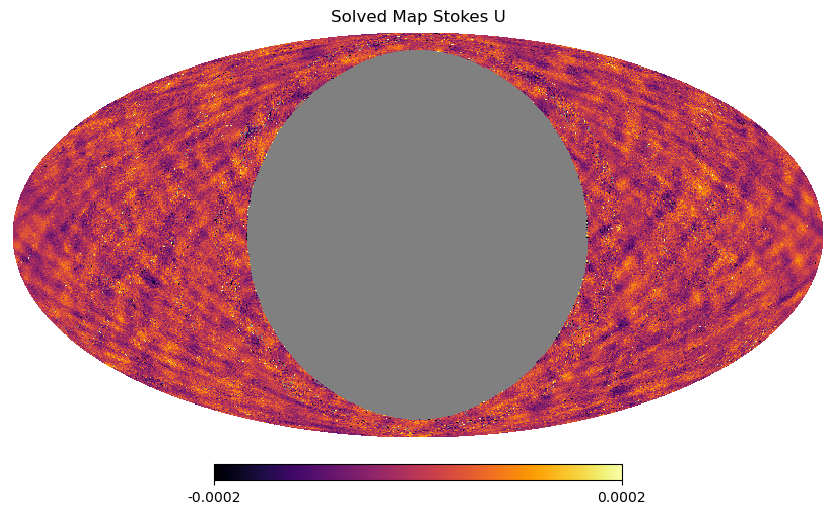

In [37]:
mapfile_root = os.path.join(mapper.output_dir, mapper.name)

hits = hp.read_map(
    f"{mapfile_root}_hits.fits", 
    dtype=np.int32
)
hp.mollview(hits, title="Solved Map Hits", cmap="inferno", min=0, max=1000)

Imap, Qmap, Umap = hp.read_map(
    f"{mapfile_root}_map.fits", 
    field=None
)

hit_pix = hits > 0
unhit_pix = np.logical_not(hit_pix)
Imap[unhit_pix] = hp.UNSEEN
Qmap[unhit_pix] = hp.UNSEEN
Umap[unhit_pix] = hp.UNSEEN

I_range = 0.005
P_range = 0.0002
hp.mollview(Imap, title="Solved Map Stokes I", cmap="inferno", min=-I_range, max=I_range)
hp.mollview(Qmap, title="Solved Map Stokes Q", cmap="inferno", min=-P_range, max=P_range)
hp.mollview(Umap, title="Solved Map Stokes U", cmap="inferno", min=-P_range, max=P_range)

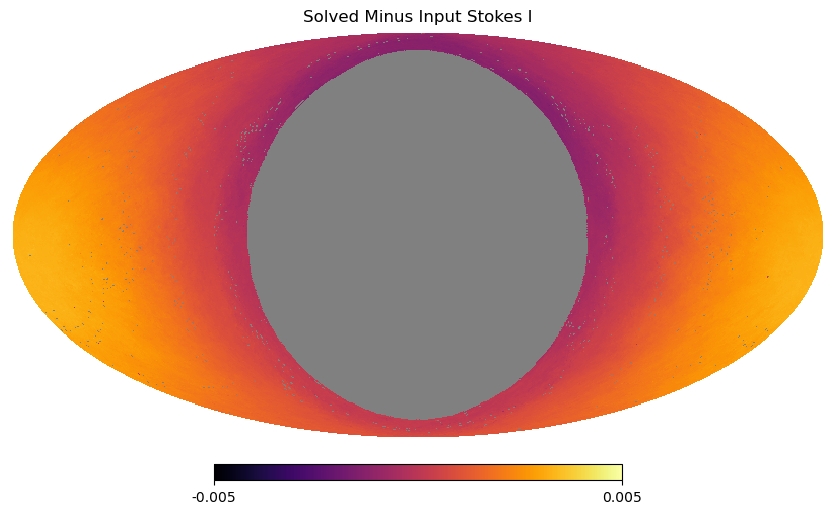

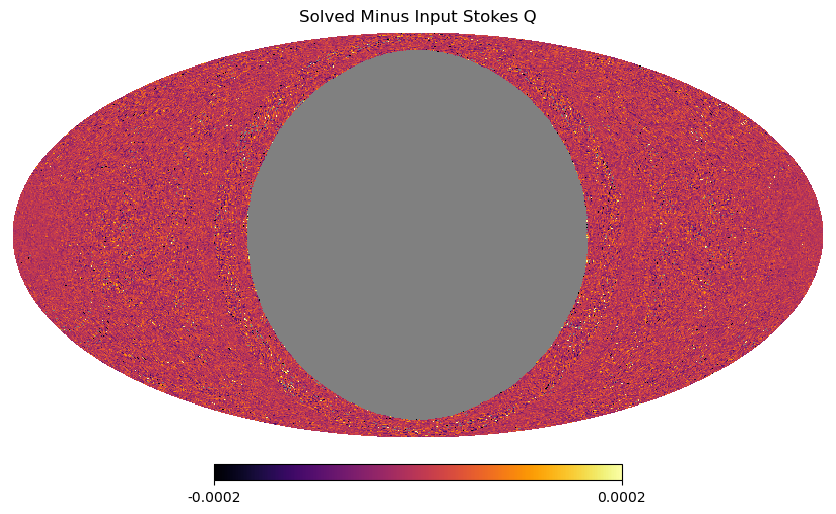

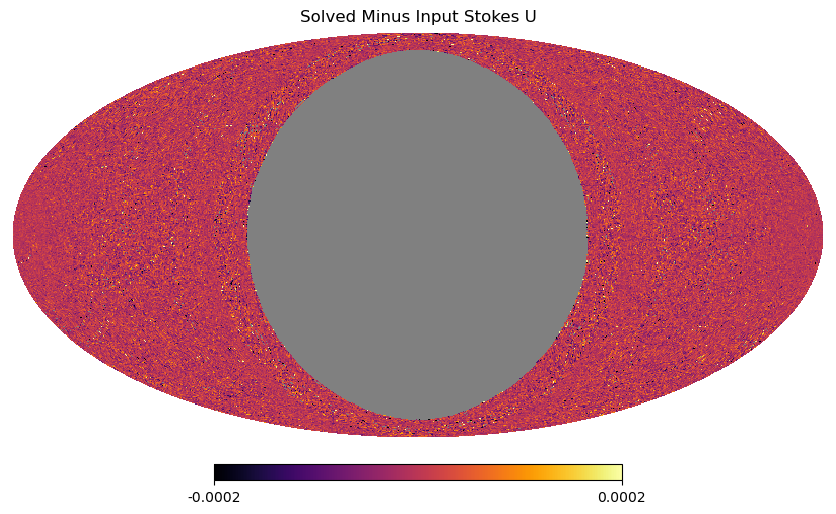

In [38]:
# Plot the residual
Idiff = Imap - fake_I
Qdiff = Qmap - fake_Q
Udiff = Umap - fake_U
Idiff[unhit_pix] = hp.UNSEEN
Qdiff[unhit_pix] = hp.UNSEEN
Udiff[unhit_pix] = hp.UNSEEN

hp.mollview(Idiff, title="Solved Minus Input Stokes I", cmap="inferno", min=-I_range, max=I_range)
hp.mollview(Qdiff, title="Solved Minus Input Stokes Q", cmap="inferno", min=-P_range, max=P_range)
hp.mollview(Udiff, title="Solved Minus Input Stokes U", cmap="inferno", min=-P_range, max=P_range)